In [300]:
import re

import kaggle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

pd.set_option('display.max_colwidth', None)

In [301]:
downloads = [
    'punkt',
    'punkt_tab',
    'stopwords',
    'wordnet',
    'omw-1.4',
    'averaged_perceptron_tagger_eng'
]
for item in downloads:
    nltk.download(item)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\visha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\visha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\visha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\visha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\visha\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\visha\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       d

In [302]:
kaggle.api.authenticate()
kaggle.api.dataset_download_files('team-ai/spam-text-message-classification',unzip=True,path='./data')

Dataset URL: https://www.kaggle.com/datasets/team-ai/spam-text-message-classification


In [303]:
df = pd.read_csv('./data/SPAM text message 20170820 - Data.csv')
df

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"
...,...,...
5567,spam,"This is the 2nd time we have tried 2 contact u. U have won the £750 Pound prize. 2 claim is easy, call 087187272008 NOW1! Only 10p per minute. BT-national-rate."
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other suggestions?"
5570,ham,The guy did some bitching but I acted like i'd be interested in buying something else next week and he gave it to us for free


In [304]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [305]:
df.Category.value_counts()

Category
ham     4825
spam     747
Name: count, dtype: int64

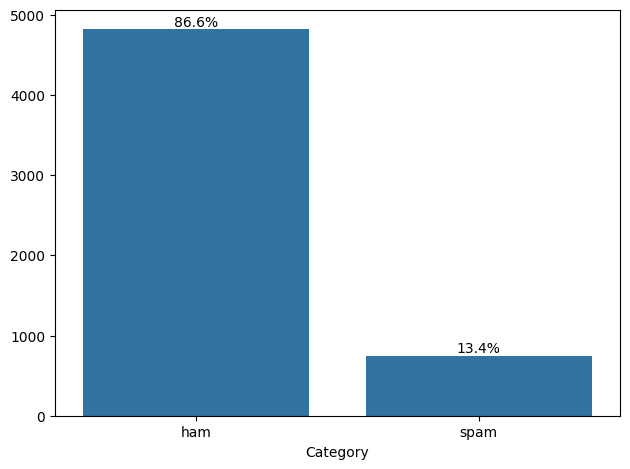

In [306]:
counts = df['Category'].value_counts()
ax = sns.barplot(x=counts.index, y=counts.values)

total = counts.sum()
for i, v in enumerate(counts.values):
    ax.text(i, v, f"{v/total:.1%}", ha='center', va='bottom')
plt.tight_layout()
plt.show()

In [307]:
# LabelEncoding the category
df['Category'] = df['Category'].map({'ham': 0, 'spam': 1})

In [308]:
# Checking for Emoji as in this case (Sentiment analysis) it important
emoji_pattern = re.compile(
    "["
    "\U0001F600-\U0001F64F"  # emoticons
    "\U0001F300-\U0001F5FF"  # symbols & pictographs
    "\U0001F680-\U0001F6FF"  # transport & map
    "\U0001F700-\U0001F77F"
    "\U0001F780-\U0001F7FF"
    "\U0001F800-\U0001F8FF"
    "\U0001F900-\U0001F9FF"
    "\U0001FA00-\U0001FAFF"
    "]+",
    flags=re.UNICODE
)

df["Message"].apply(lambda x: bool(emoji_pattern.search(str(x)))).value_counts()

Message
False    5572
Name: count, dtype: int64

# No Emoji is present

In [309]:
# Function to clean text and normalizing
def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)        # HTML
    text = re.sub(r'\d+', '', text)          # numbers
    text = re.sub(r'[^\w\s]', '', text)      # punctuation
    text = re.sub(r'[^\x00-\x7F]+', '', text) # emojis
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [310]:
# Removing the punctuation mark and lowercasing the msg
df['text'] = df['Message'].apply(clean_text)
df.drop(columns='Message',inplace=True)

In [311]:
#Tokenization
df['text'] = df['text'].apply(word_tokenize)

In [312]:
stop_words = set(stopwords.words('english'))
df['text'] = df['text'].apply(
    lambda x: [w for w in x if w.lower() not in stop_words]
)
df

,Category,text
0,0,"[go, jurong, point, crazy, available, bugis, n, great, world, la, e, buffet, cine, got, amore, wat]"
1,0,"[ok, lar, joking, wif, u, oni]"
2,1,"[free, entry, wkly, comp, win, fa, cup, final, tkts, st, may, text, fa, receive, entry, questionstd, txt, ratetcs, apply, overs]"
3,0,"[u, dun, say, early, hor, u, c, already, say]"
4,0,"[nah, dont, think, goes, usf, lives, around, though]"
...,...,...
5567,1,"[nd, time, tried, contact, u, u, pound, prize, claim, easy, call, p, per, minute, btnationalrate]"
5568,0,"[b, going, esplanade, fr, home]"
5569,0,"[pity, mood, soany, suggestions]"
5570,0,"[guy, bitching, acted, like, id, interested, buying, something, else, next, week, gave, us, free]"


In [313]:
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatize_with_pos(tokens):
    pos_tags = pos_tag(tokens)
    return [
        lemmatizer.lemmatize(word, get_wordnet_pos(tag))
        for word, tag in pos_tags
    ]

df['text'] = df['text'].apply(lemmatize_with_pos)
df

,Category,text
0,0,"[go, jurong, point, crazy, available, bugis, n, great, world, la, e, buffet, cine, get, amore, wat]"
1,0,"[ok, lar, joking, wif, u, oni]"
2,1,"[free, entry, wkly, comp, win, fa, cup, final, tkts, st, may, text, fa, receive, entry, questionstd, txt, ratetcs, apply, over]"
3,0,"[u, dun, say, early, hor, u, c, already, say]"
4,0,"[nah, dont, think, go, usf, life, around, though]"
...,...,...
5567,1,"[nd, time, try, contact, u, u, pound, prize, claim, easy, call, p, per, minute, btnationalrate]"
5568,0,"[b, go, esplanade, fr, home]"
5569,0,"[pity, mood, soany, suggestion]"
5570,0,"[guy, bitch, act, like, id, interested, buying, something, else, next, week, give, u, free]"


In [314]:
df['text'] = df['text'].apply(lambda x : ' '.join(x))
df

,Category,text
0,0,go jurong point crazy available bugis n great world la e buffet cine get amore wat
1,0,ok lar joking wif u oni
2,1,free entry wkly comp win fa cup final tkts st may text fa receive entry questionstd txt ratetcs apply over
3,0,u dun say early hor u c already say
4,0,nah dont think go usf life around though
...,...,...
5567,1,nd time try contact u u pound prize claim easy call p per minute btnationalrate
5568,0,b go esplanade fr home
5569,0,pity mood soany suggestion
5570,0,guy bitch act like id interested buying something else next week give u free


In [315]:
X = df['text']
y = df['Category']

# 2. Train-Test Split
# It is crucial to split BEFORE vectorizing to prevent "data leakage" 
# (where the model accidentally learns words from the test set).
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")

Training Data Shape: (4457,)
Testing Data Shape: (1115,)


In [316]:
# 3. Vectorization (TF-IDF)
tfidf = TfidfVectorizer(max_features=3000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [317]:
X_test_tfidf

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 7444 stored elements and shape (1115, 3000)>

In [318]:
# 4. Model Training
# MultinomialNB is excellent for discrete counts/frequencies in text
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

# 5. Prediction
y_pred = nb_model.predict(X_test_tfidf)

print("Model Training Complete.")

Model Training Complete.


Accuracy: 0.9677

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       968
           1       1.00      0.76      0.86       147

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.97      0.97      1115



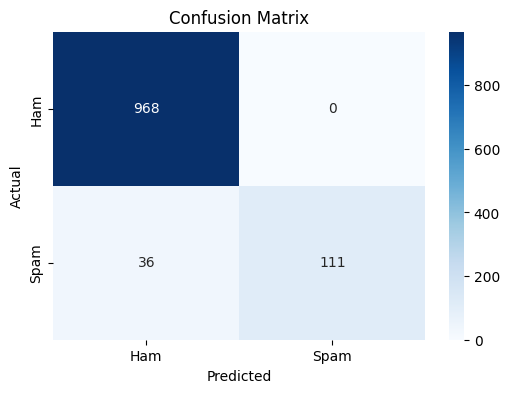

In [319]:
# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Detailed Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix Visualization
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

Training models...
--> Processing Naive Bayes...

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       968
           1       1.00      0.76      0.86       147

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.97      0.97      1115



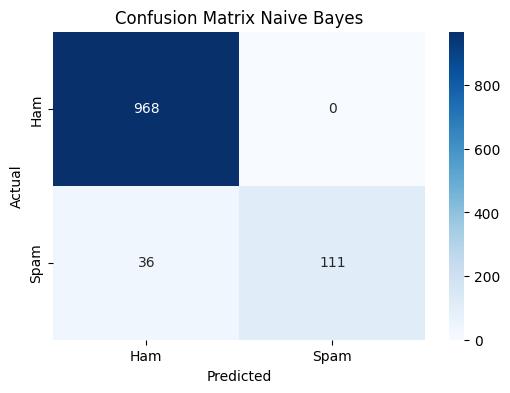

--> Processing Logistic Regression...

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       968
           1       0.85      0.91      0.88       147

    accuracy                           0.97      1115
   macro avg       0.92      0.94      0.93      1115
weighted avg       0.97      0.97      0.97      1115



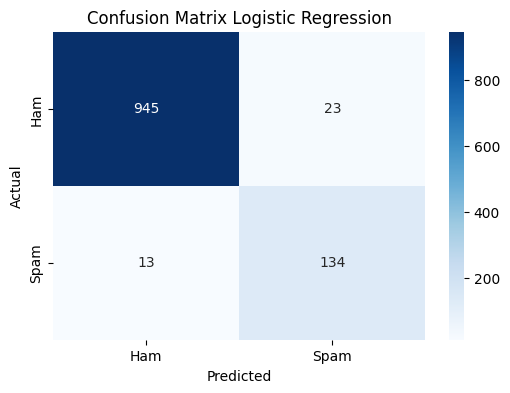

--> Processing Support Vector Machine...

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       968
           1       0.91      0.90      0.91       147

    accuracy                           0.98      1115
   macro avg       0.95      0.95      0.95      1115
weighted avg       0.98      0.98      0.98      1115



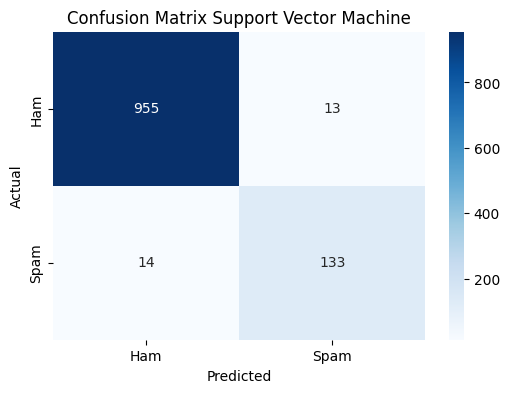

--> Processing Random Forest...

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       968
           1       0.98      0.82      0.89       147

    accuracy                           0.97      1115
   macro avg       0.98      0.91      0.94      1115
weighted avg       0.97      0.97      0.97      1115



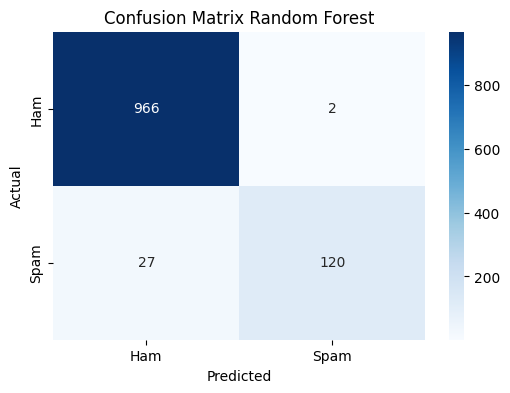

,Model,Accuracy,Precision (Spam),Recall (Spam),F1 Score
2,Support Vector Machine,0.975785,0.910959,0.904762,0.907850
3,Random Forest,0.973991,0.983607,0.816327,0.892193
1,Logistic Regression,0.967713,0.853503,0.911565,0.881579
0,Naive Bayes,0.967713,1.000000,0.755102,0.860465


In [321]:
# 1. Define the models dictionary
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000,class_weight='balanced'),
    "Support Vector Machine": SVC(kernel='linear',class_weight='balanced'), # Linear kernel is usually best for text
    "Random Forest": RandomForestClassifier(n_estimators=100)
}

# 2. Train and Evaluate
results = []

print("Training models...")
for name, model in models.items():
    print(f"--> Processing {name}...")
    model.fit(X_train_tfidf, y_train)
    y_pred_new = model.predict(X_test_tfidf)
    
    # Calculate metrics
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred_new),
        "Precision (Spam)": precision_score(y_test, y_pred_new),
        "Recall (Spam)": recall_score(y_test, y_pred_new),
        "F1 Score": f1_score(y_test, y_pred_new)
    })

    # Detailed Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_new))

    # Confusion Matrix Visualization
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred_new), annot=True, fmt='d', cmap='Blues',
                xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Confusion Matrix {name}')
    plt.show()

# 3. Create a DataFrame for comparison
results_df = pd.DataFrame(results).sort_values(by="F1 Score", ascending=False)
results_df